In [435]:
import numpy as np
import pandas as pd
import networkx as nx
import random
from random import sample
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import figure
import ast
from scipy import spatial
import csv
from tqdm.notebook import tqdm
import re
%matplotlib inline

In [436]:
mpl.rc('xtick', labelsize=14, color="#222222") 
mpl.rc('ytick', labelsize=14, color="#222222") 
mpl.rc('font', **{'family':'sans-serif','sans-serif':['Arial']})
mpl.rc('font', size=16)
mpl.rc('xtick.major', size=6, width=1)
mpl.rc('xtick.minor', size=3, width=1)
mpl.rc('ytick.major', size=6, width=1)
mpl.rc('ytick.minor', size=3, width=1)
mpl.rc('axes', linewidth=1, edgecolor="#222222", labelcolor="#222222")
mpl.rc('text', usetex=False, color="#222222")

In [298]:
df_total = pd.read_excel('data/all_data.xlsx', sheet_name='percentChange',engine='openpyxl')
stocks = pd.read_csv('data/stocks.csv',)
links_total = pd.read_csv('data/links_total.csv',)

In [299]:
all_sectors = {}
for sect in df_total['Sector']:
    if(sect in all_sectors):
        all_sectors[sect]+=1
    else:
        all_sectors[sect]=1
sorted_sectors = sorted(all_sectors.items(),key=lambda x:x[1],reverse=True)

### Identifying Popular Sectors
The snippet below prints all the sectors from our raw data, these include banking, software, pharmaceuticals and many more.
With these sectors now identified, we can begin exploring the relationship between them, and see how stocks within the same sectors relate to eachother.

In [300]:
for sector in sorted_sectors:
    print(sector)

('No Sector', 375)
('Banks', 246)
('Biotechnology', 126)
('Oil, Gas & Consumable Fuels', 122)
('Equity Real Estate Investment Trusts ...', 92)
('Metals & Mining', 89)
('Machinery', 85)
('Health Care Equipment & Supplies', 83)
('Electronic Equipment, Instruments & C...', 78)
('Insurance', 75)
('Capital Markets', 75)
('Semiconductors & Semiconductor Equipment', 68)
('Software', 66)
('Specialty Retail', 58)
('Commercial Services & Supplies', 52)
('IT Services', 52)
('Chemicals', 51)
('Hotels, Restaurants & Leisure', 50)
('Pharmaceuticals', 48)
('Thrifts & Mortgage Finance', 47)
('Health Care Providers & Services', 46)
('Communications Equipment', 45)
('Food Products', 44)
('Media', 42)
('Household Durables', 39)
('Aerospace & Defense', 37)
('Professional Services', 35)
('Energy Equipment & Services', 32)
('Textiles, Apparel & Luxury Goods', 29)
('Electrical Equipment', 28)
('Electric Utilities', 28)
('Trading Companies & Distributors', 25)
('Building Products', 23)
('Road & Rail', 22)
('R

In [301]:
top_sectors = [
'No Sector',
'Banks',
'Biotechnology',
'Oil, Gas & Consumable Fuels',
'Equity Real Estate Investment Trusts ',
'Metals & Mining',
'Machinery',
'Electronic Equipment, Instruments & C',
'Capital Markets',
'Health Care Equipment & Supplies',
'Insurance',
'Semiconductors & Semiconductor Equipment',
'Software',
'Specialty Retail',
'IT Services',
'Commercial Services & Supplies',
'Pharmaceuticals',
'Chemicals',
'Hotels, Restaurants & Leisure',
'Thrifts & Mortgage Finance',
'Communications Equipment',
'Health Care Providers & Services',
'Food Products',
'Media',
'Aerospace & Defense',
'Household Durables',
'Professional Services',
'Energy Equipment & Services',
'Blank Check / SPAC',
'Electrical Equipment',
'Textiles, Apparel & Luxury Goods',
'Electric Utilities',
'Trading Companies & Distributors',
'Real Estate Management & Development',
'Building Products',
'Entertainment',
'Technology Hardware, Storage & Periph',
'Construction & Engineering',
'Road & Rail',
'Consumer Finance',
'Beverages',
'Auto Components',
'Diversified Telecommunication Services',
'Life Sciences Tools & Services',
'Multi-Utilities',
'Internet & Direct Marketing Retail',
'Personal Products',
'Diversified Consumer Services',
'Mortgage Real Estate Investment Trust',
'Shell Companies',
'Marine',
'Airlines',
'Food & Staples Retailing',
'Wireless Telecommunication Services',
'Containers & Packaging',
'Software-Application',
'Water Utilities',
'Gas Utilities',
'Air Freight & Logistics',
'Leisure Products',
'Health Care Technology',
'Interactive Media & Services',
'Household Products',
'Automobiles',
'Construction Materials',
'Multiline Retail',
'Independent Power and Renewable Elect',
'Paper & Forest Products',
'Diversified Financial Services',
'Industrial Conglomerates',
'Distributors',
'Medical Instruments & Supplies',
'Tobacco',
'Information Technology Services',
'Medical Devices',
'Drug Manufacturers-Specialty & Generic',
'Asset Management',
'Specialty Industrial Machinery',
'Telecom Services',
'Furnishings, Fixtures & Appliances',
'Banks-Regional',
'Transportation Infrastructure',
'Health Information Services',
'Electrical Equipment & Parts',
'Other Industrial Metals & Mining',
'Scientific & Technical Instruments',
'Gold',
'Security & Protection Services',
'Auto Parts',
'Gambling',
'Communication Equipment',
'Software-Infrastructure',
'Health Care',
'Medical Care Facilities',
'Computer Hardware',
'Building Products & Equipment',
'Auto Manufacturers',
'Electronic Components',
'Agricultural Inputs',
'Internet Content & Information',
'Securities and Commodity Exchanges',
'Farm Products',
'Utilities-Renewable',
'Industrial Distribution',
'Electronic Gaming & Multimedia',
'Education & Training Services',
'Pharmaceutical Retailers',
'Oil & Gas Drilling',
'Banks-Diversified',
'Internet Retail',
'Rental & Leasing Services',
'Staffing & Employment Services',
'Auto & Truck Dealerships',
'Electromedical and Electrotherapeutic',
'REIT-Mortgage',
'Petroleum Refineries',
'Advertising Agencies',
'Diagnostics & Research',
'Specialty Business Services',
'Uranium',
'Engineering & Construction',
'Packaged Foods',
'REIT-Residential',
'Beverages-Wineries & Distilleries',
'Semiconductors',
]

### Getting Stocks by sector
After we have obtained the top sectors, the snippet of code below goes through the data and finds all the stocks corresponding to our top sectors

In [302]:
stocks_by_sector = []
for sector in top_sectors:
    stocks = df_total.loc[df_total['Sector'] == sector]
    value = (sector,stocks)
    stocks_by_sector.append(value)

### Calculating Average Intra-Sector Correlation
The following code blocks calculate the average weight of a link between all the stocks in a given sector. For example, in the Bank sector, the functions will go and obtain the links from one bank stock to every other bank stock, and add them to the total. Then this total will be divided by the number of links, to obtain the average weight. This is in hopes of answering our third and fourth research questions.

In [303]:
def calculateIntraSectorWeight(sector):
    max_corr = (0,"stock","stock")
    min_corr = (0,"stock","stock")
    sum_of_links = 0
    link_count = 0
    sector_index = top_sectors.index(sector)
    df = stocks_by_sector[sector_index][1]
    num_of_stocks = df.shape[0]
    for i in tqdm(range(num_of_stocks)):
        first_stock = df.iloc[i,2:]
        for j in range(i+1,num_of_stocks):
            second_stock = df.iloc[j,2:]
            result = 1-spatial.distance.cosine(first_stock,second_stock)
            if(result>max_corr[0]):
                max_corr = (result,df.iloc[i,0],df.iloc[j,0])
            if(result<min_corr[0]):
                min_corr = (result,df.iloc[i,0],df.iloc[j,0])
            sum_of_links += result
            link_count += 1
    if(link_count < 1):
        return 0,1,"N/A","N/A"
    average_link = sum_of_links / link_count
    return average_link,num_of_stocks,max_corr,min_corr

In [304]:
def getAllIntraSectorCorrelations(df):
    for count,sector in enumerate(top_sectors):
        avg,num_stocks,max_corr, min_corr = calculateIntraSectorWeight(sector)
        df.loc[count] = [(str(sector)+"("+str(num_stocks)+")"),
                         avg,
                         (max_corr[0],max_corr[1],max_corr[2]),
                         (min_corr[0],min_corr[1],min_corr[2])]

In [305]:
df_intra = pd.DataFrame(columns=["Sector","Average Correlation","Max Correlation","Min Correlation"])
getAllIntraSectorCorrelations(df_intra)

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

#### Filtering & Exporting the Data to Excel

In [306]:
def intraThresh(sector, corr):
    stocks = int(re.sub("[^0-9]", "",sector))
    return stocks*corr

In [307]:
for index, row in df_intra.iterrows():
    total_stocks = intraThresh(row['Sector'],row['Average Correlation'])
    if(total_stocks < 2.5):
        df_intra.drop(index, inplace=True)

In [308]:
df_intra = df_intra.sort_values('Average Correlation', ascending=False)
df_intra

,Sector,Average Correlation,Max Correlation,Min Correlation
44,Multi-Utilities(18),0.540965,"(0.9085339576171104, CMS, WEC)","(0, stock, stock)"
54,Containers & Packaging(12),0.486125,"(0.73334832175076, IP, PKG)","(0, stock, stock)"
27,Energy Equipment & Services(32),0.485446,"(0.8882941728141304, HAL, SLB)","(0, stock, stock)"
69,Industrial Conglomerates(6),0.480197,"(0.7423969814905563, HON, ROP)","(0, stock, stock)"
38,Road & Rail(22),0.478792,"(0.829895696574278, CSX, NSC)","(0, stock, stock)"
51,Airlines(14),0.450195,"(0.8928999467636979, CEA, ZNH)","(0, stock, stock)"
64,Construction Materials(8),0.448190,"(0.8092591332032857, MLM, VMC)","(0, stock, stock)"
31,Electric Utilities(28),0.429635,"(0.8963693868337042, LNT, XEL)","(-0.12298661607003947, EDN, FE)"
41,Auto Components(21),0.418966,"(0.7883215563934879, BWA, DAN)","(0, stock, stock)"
34,Building Products(23),0.410096,"(0.7005375149402394, LII, MAS)","(-0.08748488327308834, AOS, APT)"


In [309]:
df_intra.to_excel("data/sector_correlations/total_intra.xlsx",sheet_name="Sheet1",index=False)

### Calculating Average Intra-Sector Correlation
The next few blocks of code perform a similar calculation as above, however this time we are comparing the stocks in different sectors to eachother, rather than looking within the same sector.

In [310]:
def calculateIntraSectorCorrelations(sector1,sector2):
    sector1_index = top_sectors.index(sector1)
    df1 = stocks_by_sector[sector1_index][1]
    sector1_stock_count = df1.shape[0]
    
    sector2_index = top_sectors.index(sector2)
    df2 = stocks_by_sector[sector2_index][1]
    sector2_stock_count = df2.shape[0]
    
    link_count = 0
    sum_of_links = 0
    max_corr = (0,"stock","stock")
    min_corr = (0,"stock","stock")
    for i in range(sector1_stock_count):
        first_stock = df1.iloc[i,2:]
        for j in range(sector2_stock_count):
            second_stock = df2.iloc[j,2:]
            result = 1-spatial.distance.cosine(first_stock,second_stock)
            if(result>max_corr[0]):
                max_corr = (result,df1.iloc[i,0],df2.iloc[j,0])
            if(result<min_corr[0]):
                min_corr = (result,df1.iloc[i,0],df2.iloc[j,0])
            sum_of_links += result
            link_count += 1
            
    if(link_count < 1):
        return 0,1,1,"N/A","N/A"
    average_link = sum_of_links / link_count
    
    return average_link, sector1_stock_count, sector2_stock_count, max_corr, min_corr

In [311]:
def getAllInterSectorCorrelations(df):
    num_of_sectors = len(top_sectors)
    count = 1
    for i in tqdm(range(num_of_sectors)):
        sector1 = top_sectors[i]
        for j in range(i+1,num_of_sectors):
            sector2 = top_sectors[j]
            avg_sector_corr, sector1_stock_count, sector2_stock_count, max_corr, min_corr = calculateIntraSectorCorrelations(sector1,sector2)
            df.loc[count] = [(str(sector1)+"("+str(sector1_stock_count)+")"),
                             (str(sector2)+"("+str(sector2_stock_count)+")"),
                             avg_sector_corr,
                             (max_corr[0],max_corr[1],max_corr[2]),
                             (min_corr[0],min_corr[1],min_corr[2])]
            count += 1

### Thresholding and exporting Data
Due to the large number of sectors with single stocks, or small stock counts, we need to remove correlations that are  on a small number of nodes (<20).

In [312]:
df_inter = pd.DataFrame(columns=["Sector1","Sector2","Average Correlation","Max Correlation","Min Correlation"])
getAllInterSectorCorrelations(df_inter)

  0%|          | 0/125 [00:00<?, ?it/s]

In [321]:
def threshHold(sector1, sector2):
    stocks1 = int(re.sub("[^0-9]", "",sector1))
    stocks2 = int(re.sub("[^0-9]", "",sector2))
    if stocks1 < 4 or stocks2 < 4:
        return 0
    return stocks1+stocks2

In [322]:
for index, row in df_inter.iterrows():
    total_stocks = threshHold(row['Sector1'],row['Sector2'])
    if(total_stocks < 20):
        df_inter.drop(index, inplace=True)

In [325]:
df_inter = df_inter.sort_values('Average Correlation',ascending=False)
df_inter

,Sector1,Sector2,Average Correlation,Max Correlation,Min Correlation
3392,Electric Utilities(28),Multi-Utilities(18),0.476321,"(0.9167574662755461, XEL, WEC)","(-0.12302158185388956, EDN, WEC)"
792,Machinery(85),Industrial Conglomerates(6),0.429769,"(0.8047939223090763, PH, HON)","(-0.014665736301675336, BIMI, ROP)"
4040,Road & Rail(22),Industrial Conglomerates(6),0.424758,"(0.6942029569397065, UNP, HON)","(0, stock, stock)"
3690,Building Products(23),Industrial Conglomerates(6),0.410057,"(0.7180570917379496, TT, HON)","(-0.08169640206394724, APT, MMM)"
777,Machinery(85),Containers & Packaging(12),0.406442,"(0.7146423750498736, IEX, GPK)","(-0.0393267224919831, BIMI, SLGN)"
...,...,...,...,...,...
301,Biotechnology(126),Water Utilities(12),0.050523,"(0.31537663469642263, ANIK, SBS)","(-0.24626580326117842, IBIO, SJW)"
289,Biotechnology(126),Multi-Utilities(18),0.049226,"(0.40079293853031706, BTX, UTL)","(-0.3077837198006852, ATHX, CNP)"
4987,Marine(15),Household Products(10),0.041388,"(0.3304734478068596, MATX, WDFC)","(-0.19266368211812823, ESEA, KMB)"
276,Biotechnology(126),Electric Utilities(28),0.040257,"(0.32005758703852427, ABUS, PCG)","(-0.26812786369252684, IBIO, PPL)"


In [324]:
df_inter.to_excel("data/sector_correlations/total_inter.xlsx",sheet_name="Sheet1",index=False)

### Repeating the Process for yearly data
Now that we have found the intra sector correlations for the total data, we can apply the same idea to the yearly data to find trends over time.

In [317]:
def calculateIntraSectorWeightYearly(sector,start_col):
    max_corr = (0,"stock","stock")
    min_corr = (0,"stock","stock")
    sum_of_links = 0
    link_count = 0
    sector_index = top_sectors.index(sector)
    df = stocks_by_sector[sector_index][1]
    df = df.iloc[:,start_col:start_col+12]
    num_of_stocks = df.shape[0]
    for i in range(num_of_stocks):
        first_stock = df.iloc[i,2:]
        for j in range(i+1,num_of_stocks):
            second_stock = df.iloc[j,2:]
            result = 1-spatial.distance.cosine(first_stock,second_stock)
            if(result>max_corr[0]):
                max_corr = (result,df.iloc[i,0],df.iloc[j,0])
            if(result<min_corr[0]):
                min_corr = (result,df.iloc[i,0],df.iloc[j,0])
            sum_of_links += result
            link_count += 1
    if(link_count < 1):
        return 0,1
    average_link = sum_of_links / link_count
    
    return average_link,num_of_stocks

In [318]:
def getAllIntraSectorCorrelationsYearly(df,start_col):
    for count,sector in enumerate(top_sectors):
        avg,num_stocks = calculateIntraSectorWeightYearly(sector,start_col)
        df.loc[count] = [(str(sector)+"("+str(num_stocks)+")"),avg]

In [319]:
def filterIntra(df_intra):
    for index, row in df_intra.iterrows():
        total_stocks = intraThresh(row['Sector'],row['Average Correlation'])
        if(total_stocks < 4):
            df_intra.drop(index, inplace=True)

In [ ]:
start_col = 2
for year in tqdm(range(2010,2020)):
    # Setup and file names
    intra_file_name = "data/sector_correlations/"+str(year)+"_intra.xlsx"
    inter_file_name = "data/sector_correlations/"+str(year)+"_inter.xlsx"
    
    # calculate yearly intra correlation for all sectors + filter
    df_intra_yearly = pd.DataFrame(columns=["Sector","Average Correlation"])
    getAllIntraSectorCorrelationsYearly(df_intra_yearly,start_col)
    filterIntra(df_intra_yearly)
    df_intra_yearly = df_intra_yearly.sort_values('Average Correlation', ascending=False)
    
    # export
    df_intra_yearly.to_excel(intra_file_name,sheet_name="Sheet1",index=False)
    start_col += 12

### Visualizing the Data for Inter Similarities

In [464]:
x_intra = []
y_intra = []
for index,row in df_intra.iterrows():
    x_intra.append(row['Sector'])
    y_intra.append(row['Average Correlation'])
x_intra.reverse()
y_intra.reverse()

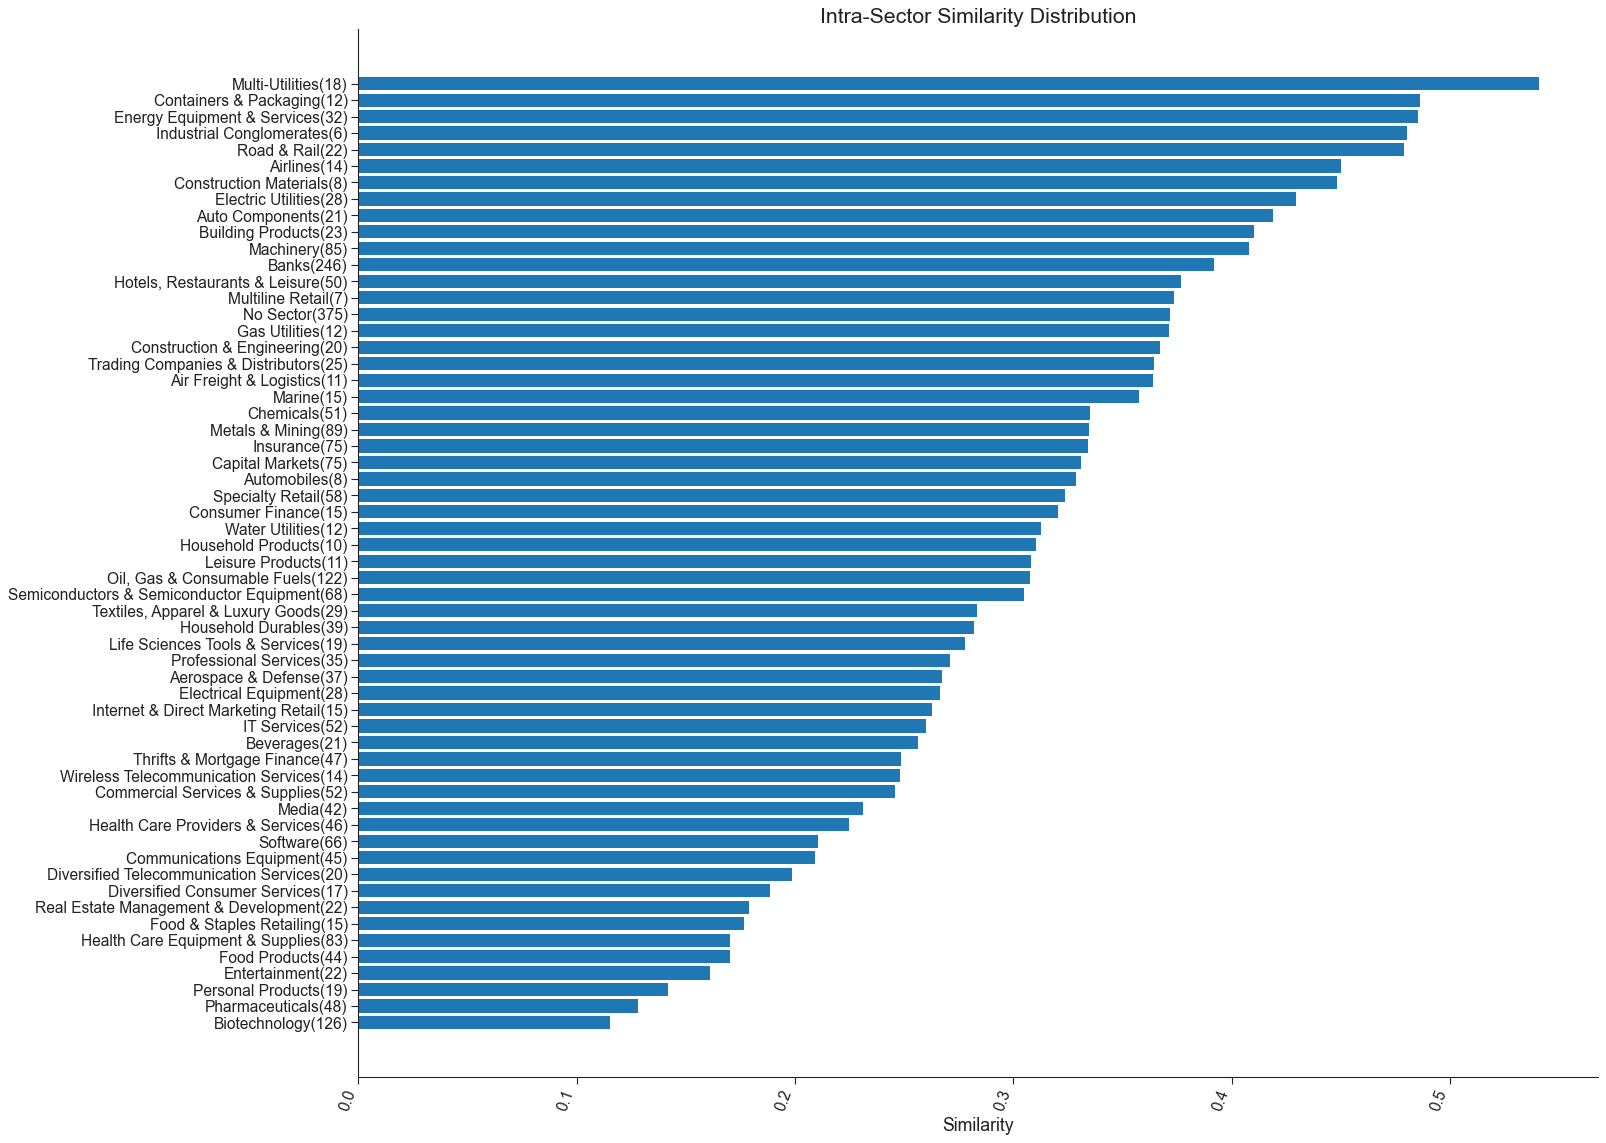

In [470]:
figure(figsize=(20, 17), dpi=80)
plt.barh(x_intra,y_intra)
plt.title("Intra-Sector Similarity Distribution")
plt.xlabel("Similarity")
plt.xticks(rotation=70, ha='right')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.show()

### Visualizing the Data for Intra Similarities


In [455]:
x1 = df_inter['Sector1'].values
x2 = df_inter['Sector2'].values
y = df_inter['Average Correlation'].values

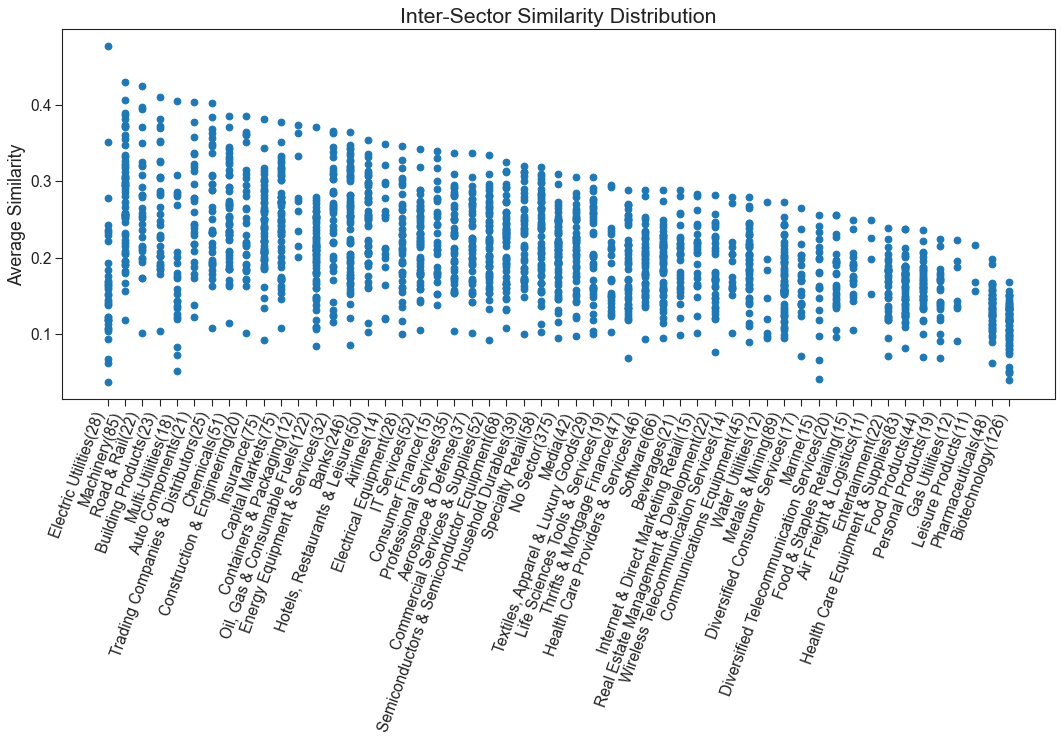

In [456]:
figure(figsize=(16, 6), dpi=80)
plt.scatter(x1,y)
plt.title("Inter-Sector Similarity Distribution")
plt.ylabel("Average Similarity")
plt.xticks(rotation=70, ha='right')
plt.show()

In [401]:
df_inter2 = df_inter

In [403]:
sector_map = {} 
for x in df_intra['Sector']:
    sector_map[x] = 0

In [421]:
for sec in sector_map:
    count = 0
    sum_so_far = 0
    for index,row in df_inter2.iterrows():
        if row['Sector1'] == sec or row['Sector2']==sec:
            sum_so_far += row['Average Correlation']
            count += 1
    sector_map[sec] = sum_so_far

In [446]:
sector_map = dict(sorted(sector_map.items(), key=lambda item: item[1],reverse=True))

In [423]:
x = []
y = []
for i in sector_map:
    x.append(i)
    y.append(sector_map[i])

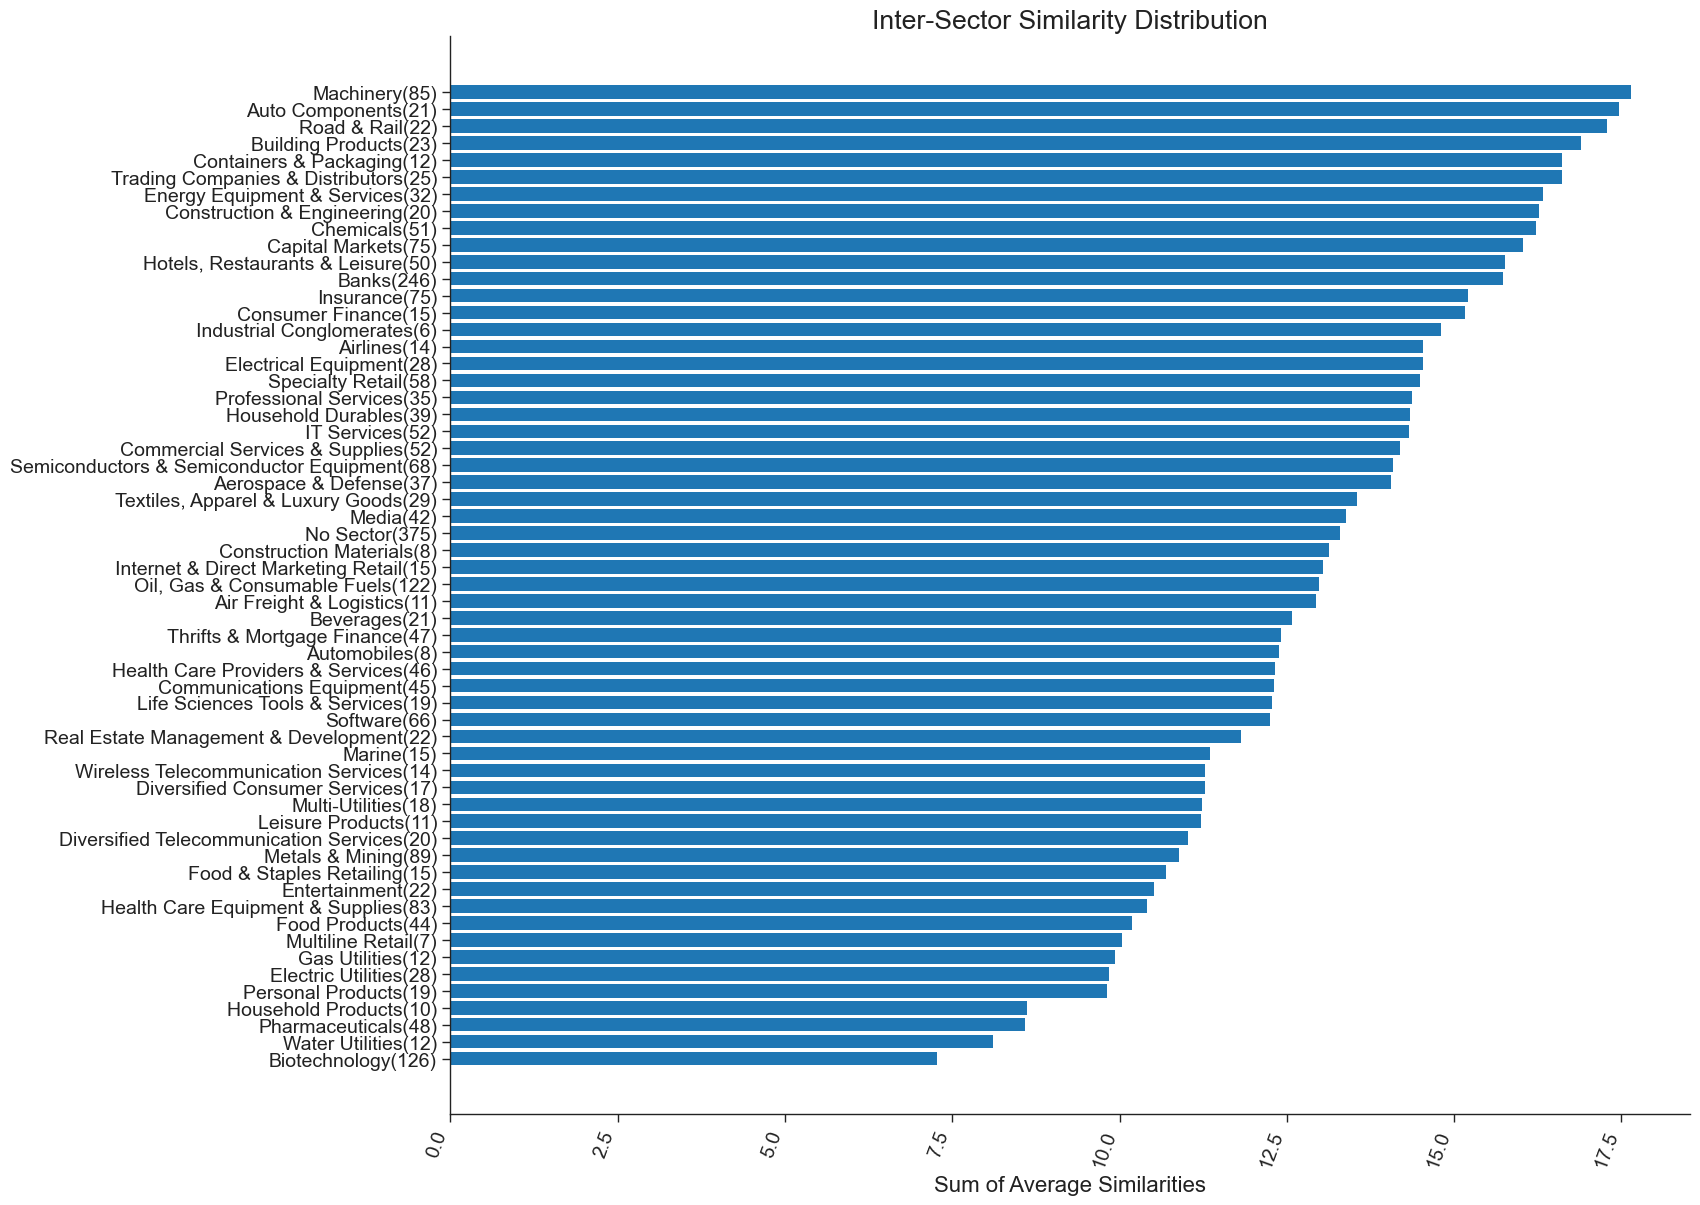

In [452]:
figure(figsize=(16, 14))
plt.barh(x,y)
plt.title("Inter-Sector Similarity Distribution")
plt.xlabel("Sum of Average Similarities")
plt.xticks(rotation=70, ha='right')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.show()